# Learning weight decay hyperparameters in Logistic Regression

The goal of this experiment is to automatically learn how to tune weight decay parameters for Logistic Regression. Using a weight decay loss is known to reduce overfitting in NN training (be it for regression or classification).

Here, we apply this regularization to a classification problem. We consider a dataset called cover type, whih aims at classifying the cover type of different locations on Earth based on a large number of predictors (measurements carried out on-site). Features can be numerical or categorical. They include local elevation, slope, distance to hydrology, orientation, average illumination, but also presence or not of different elements in the soil. There are 7 different types of forest cover that are to be classified, based on more than 500k data points. In this lab, we will only use 10% of it in total. All the information on the data can be found here:

https://archive.ics.uci.edu/ml/datasets/covertype

The data has $d = 54$ features, and there are $K = 7$ classes. Assuming the labels $\mathbf{y}$ are one-hot encoded, the model writes:
\begin{equation*}
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{Wx} + \mathbf{w}_0)
\end{equation*}
<!-- 
We will write $\mathbf{Wx}$ instead of $ \mathbf{Wx} + \mathbf{w}_0$ to simplify notations (assuming we add a 1 coordinate to each orginal data point $\mathbf{x}$, and a row to the original matrix $\mathbf{W}$ to account for the bias). -->

For short, we will write $\mathbf{w}$ a vector containing all the $d$ parameters of the model (how many are there?)

The cost function to train the model is then:

\begin{equation*}
\mathbf{w}({ \boldsymbol{\lambda}}) = \underset{\mathbf{w} \in \mathbb{R}^{m}}{\textrm{arg min}} \ f(\mathbf{w},\boldsymbol{\lambda}) := \sum_{ n\in \mathcal{D}_{train}}  CE_n(\mathbf{w})  + \boldsymbol{\lambda}^T (\mathbf{w}\odot  \mathbf{w}) 
\end{equation*}

where $CE$ is the cross-entropy function composed with our model (thus seen as a function of the model parameters), applied on a single data point.

where $\odot$ is the Hadamard (elementwise) product. Then $\boldsymbol{\lambda}^T (\mathbf{w}\odot  \mathbf{w}) = \sum_{i=1}^{m} \lambda_i w_i^²$

Usually, in Machine Learning, we use a validation dataset to control overfitting of the model, and possibly a test data that on which performance will be measured completely independently of the model training.

Here our objective will be to optimize the hyperparameters (one weight decay hyperparameter for each of the weights of the model) so that the Cross Entropy loss over the validation dataset is minimized. Hence we would like to solve the following bilevel optimization problem:

\begin{align*}
&\underset{\mathbf{\boldsymbol{\lambda}} \in \mathbb{R}^{m}}{\textrm{arg min}} \ F(\mathbf{w}) := \sum_{n\in \mathcal{D}_{val}} CE_n(\mathbf{w}(\boldsymbol{\lambda}))  \\
&\textrm{s.t.}  \  \mathbf{w}({ \boldsymbol{\lambda}}) = \underset{\mathbf{w} \in \mathbb{R}^{m}}{\textrm{arg min}} \ f(\mathbf{w}, \boldsymbol{\lambda}) := \sum_{ n\in \mathcal{D}_{train}}  CE_n(\mathbf{w})  + \boldsymbol{\lambda}^T (\mathbf{w}\odot  \mathbf{w})
\end{align*}

We will tackle this problem using implicit differentiation. This means we will repeat the following steps:

1) Compute the optimal value of the lower level loss on the training set using pytorch, and detach the computed value from the computation graph

2) Compute the derivative of the fixed point using implicit differentiation, computing the needed required terms using autograds (or a closed form derivative)

3) Compute the gradient of the upper level loss wrt to the lower level variable using autograd, and then wrt to the lower level variable with the chain rule

4) Perform a projected gradient descent step on the vector of hyperparameters to decrease the upper level loss


In [1]:
# imports

import torch
from matplotlib import pyplot as plt
import numpy as np
import random

torch.manual_seed(0) # fix seed for reproducibility


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

!ls "/content/gdrive/MyDrive/AI_for_geophysical_dynamics/"

folder_name = "/content/gdrive/MyDrive/AI_for_geophysical_dynamics/"

Mounted at /content/gdrive
covtype.data  covtype.info  PAN_london.tif  PAN_tren.tif


In [3]:
# reading data

import csv

with open(folder_name + 'covtype.data', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    rows = []
    for row in reader:
        rows.append(row)


In [4]:
# formatting data

N = len(rows) # number of samples
d = len(rows[0])-1 # number of attributes = len(rows[0])-1

nb_features = d

print(N)
print(d)

K = 7 # 7 classes

data = torch.zeros((N,d+1))

for i in range(N):
    data[i,:] = torch.Tensor([float(j) for j in rows[i]])

        
x = torch.FloatTensor(data[:,:nb_features]) # model inputs
y = torch.LongTensor([int(idx) for idx in data[:,-1]])-1 # last column gives the class (stored as integers)
# y = torch.Tensor(torch.nn.functional.one_hot(y,num_classes=K),dtype=torch.float)


581012
54


In [5]:
# train val test split

n = int(N/100) # using only 1% of the data

print(n)

# generate a random train/val/test split

perm = torch.randperm(N) 

x_small = x[perm[:n],:]
y_small = y[perm[:n]]

proportions = [0.4,0.4,0.2] # train/val/test

x_train = x_small[:int(n*proportions[0]),:]
x_val = x_small[int(n*proportions[0])+1:int(n*proportions[0])+int(n*proportions[1]),:]
x_test = x_small[(int(n*proportions[0])+int(n*proportions[1])):,:]

y_train = y_small[:int(n*proportions[0])]
y_val = y_small[int(n*proportions[0])+1:int(n*proportions[0])+int(n*proportions[1])]
y_test = y_small[(int(n*proportions[0])+int(n*proportions[1])):]

print(x_train.size())
print(x_val.size())
print(x_test.size())
print(y_train.size())
print(y_val.size())
print(y_test.size())

5810
torch.Size([2324, 54])
torch.Size([2323, 54])
torch.Size([1162, 54])
torch.Size([2324])
torch.Size([2323])
torch.Size([1162])


# Logistic Regression

First, we train a simple logistic regression model (without weigth decay) on the training data, and check how well it does on the validation and test data

We define the logistic regression model as a pytorch class:

In [6]:
class LogisticRegression(torch.nn.Module):
        def __init__(self, input_dim, output_dim):
            super(LogisticRegression, self).__init__()
            self.linear = torch.nn.Linear(input_dim, output_dim)    
        def forward(self, x):
                outputs = self.linear(x)
                return outputs

# instantiate model            

model = LogisticRegression(nb_features,K)

# Define cost function for the training set (depends on model weights and \lambda)

CE = torch.nn.CrossEntropyLoss()

def CE_weight_decay(x,y, lambda_, params):
    return CE(x,y) + torch.dot(lambda_, torch.pow(params,2))


The model has $54 \times 7 + 7 = 385$ parameters, so we have the same number of values for the hyperparameters to tune.

In [7]:
print(model.parameters)

<bound method Module.parameters of LogisticRegression(
  (linear): Linear(in_features=54, out_features=7, bias=True)
)>


In [8]:
from tqdm import tqdm

learning_rate = 0.00001
epochs = 100000
# epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
losses_val = []
Iterations = []

iter = 0

for epoch in tqdm(range(epochs),desc='Training Epochs'):

        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x_train) # generate model outputs

        vectorized_params = torch.nn.utils.parameters_to_vector(model.parameters())

        loss = CE_weight_decay(torch.squeeze(outputs), y_train, \
                               torch.zeros(vectorized_params.size()), vectorized_params) # compute loss

        loss.backward() # Computes the gradient of the given tensor w.r.t. the model parameters

        optimizer.step() # Updates model parameters

        iter+=1
        
        with torch.no_grad():

                # Calculating the loss and accuracy for the validation dataset

                outputs_val = torch.squeeze(model(x_val))
                loss_val = CE_weight_decay(outputs_val, y_val,torch.zeros(vectorized_params.size()), vectorized_params)

                predicted_val = torch.argmax(torch.nn.functional.softmax(outputs_val), dim = 1).detach().numpy()
                total_val = y_val.size(0)

                correct_val = np.sum(predicted_val == y_val.detach().numpy())
                accuracy_val = 100 * correct_val/total_val
                losses_val.append(loss_val.item())

                # Calculating the loss and accuracy for the train dataset
                predicted_train = torch.argmax(torch.nn.functional.softmax(outputs),dim = 1).detach().numpy()
                correct = np.sum(predicted_train == y_train.detach().numpy())
                total = y_train.size(0)
                accuracy = 100 * correct/total
                losses.append(loss.item())
                Iterations.append(iter)

                
        if iter%10000==0:

                print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
                print(f"Iteration: {iter}. \nValidation - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")

# Calculating the loss and accuracy for the validation dataset

outputs_val = torch.squeeze(model(x_val))
loss_val = CE_weight_decay(outputs_val, y_val, torch.zeros(vectorized_params.size()), vectorized_params)

predicted_val = torch.argmax(torch.nn.functional.softmax(outputs_val), dim = 1).detach().numpy()
total_val = y_val.size(0)

correct_val = np.sum(predicted_val == y_val.detach().numpy())
accuracy_val = 100 * correct_val/total_val

predicted_train = torch.argmax(torch.nn.functional.softmax(outputs),dim = 1).detach().numpy()
correct = np.sum(predicted_train == y_train.detach().numpy())
total = y_train.size(0)
accuracy_train = 100 * correct/total


Training Epochs:   0%|          | 0/100000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Training Epochs:  10%|█         | 10032/100000 [00:48<07:06, 210.72it/s]

Train -  Loss: 33.16557693481445. Accuracy: 38.68330464716007

Iteration: 10000. 
Validation - Loss: 32.979286193847656. Accuracy: 38.743004735256136


Training Epochs:  20%|██        | 20042/100000 [01:33<06:02, 220.66it/s]

Train -  Loss: 0.9041033983230591. Accuracy: 65.7487091222031

Iteration: 20000. 
Validation - Loss: 0.9246274828910828. Accuracy: 65.21739130434783


Training Epochs:  30%|███       | 30028/100000 [02:17<04:47, 243.32it/s]

Train -  Loss: 0.708656907081604. Accuracy: 70.35283993115318

Iteration: 30000. 
Validation - Loss: 0.728317141532898. Accuracy: 69.73740852346104


Training Epochs:  40%|████      | 40034/100000 [02:59<04:06, 242.97it/s]

Train -  Loss: 0.6764165759086609. Accuracy: 70.65404475043029

Iteration: 40000. 
Validation - Loss: 0.6956197023391724. Accuracy: 70.64141196728369


Training Epochs:  50%|█████     | 50035/100000 [03:42<03:23, 244.97it/s]

Train -  Loss: 0.6618586778640747. Accuracy: 71.51462994836488

Iteration: 50000. 
Validation - Loss: 0.6835415959358215. Accuracy: 71.07188979767542


Training Epochs:  60%|██████    | 60046/100000 [04:24<02:48, 237.62it/s]

Train -  Loss: 0.6528748869895935. Accuracy: 71.72977624784853

Iteration: 60000. 
Validation - Loss: 0.6789756417274475. Accuracy: 71.63151097718467


Training Epochs:  70%|███████   | 70037/100000 [05:07<02:11, 228.20it/s]

Train -  Loss: 0.6462661027908325. Accuracy: 72.1170395869191

Iteration: 70000. 
Validation - Loss: 0.6771950125694275. Accuracy: 71.63151097718467


Training Epochs:  80%|████████  | 80032/100000 [05:49<01:21, 243.53it/s]

Train -  Loss: 0.641119122505188. Accuracy: 72.41824440619621

Iteration: 80000. 
Validation - Loss: 0.6765798330307007. Accuracy: 71.45931984502798


Training Epochs:  90%|█████████ | 90038/100000 [06:31<00:40, 246.17it/s]

Train -  Loss: 0.6369762420654297. Accuracy: 72.59036144578313

Iteration: 90000. 
Validation - Loss: 0.6763851642608643. Accuracy: 71.33017649591046


Training Epochs: 100%|██████████| 100000/100000 [07:13<00:00, 230.64it/s]

Train -  Loss: 0.6336044669151306. Accuracy: 72.67641996557659

Iteration: 100000. 
Validation - Loss: 0.6766167879104614. Accuracy: 71.15798536375377



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


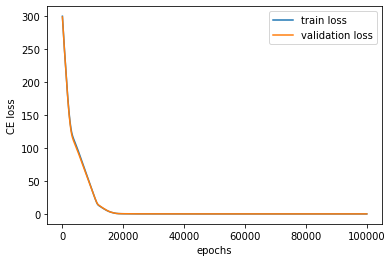

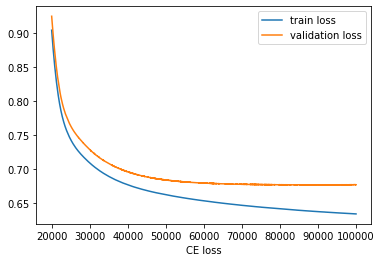

In [9]:
plt.figure()
plt.plot(torch.arange(epochs),losses)
plt.plot(torch.arange(epochs),losses_val)
plt.xlabel('epochs')
plt.ylabel('CE loss')
plt.legend(['train loss', 'validation loss'])

plt.figure()
plt.plot(torch.arange(epochs)[20000:],losses[20000:])
plt.plot(torch.arange(epochs)[20000:],losses_val[20000:])
plt.xlabel('epochs')
plt.xlabel('CE loss')
plt.legend(['train loss', 'validation loss'])

In [10]:
# performance on test set
    
outputs_test = torch.squeeze(model(x_test))

total_test = y_test.size(0)

loss_test = CE_weight_decay(outputs_test, y_test, torch.zeros(vectorized_params.size()), vectorized_params)

predicted_test = torch.argmax(torch.nn.functional.softmax(outputs_test), dim = 1).detach().numpy()
total_val = y_test.size(0)

correct_test = np.sum(predicted_test == y_test.detach().numpy())
accuracy_test = 100 * correct_test/total_test

print(loss_test)
print(accuracy_test)

tensor(0.6702, grad_fn=<AddBackward0>)
70.22375215146299


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


# Weight decay and hyperparameter tuning

The training/meta training procedure is a double loop: We obtain the solution for the (convex) lower level by fitting the model on the training set, as usual. We use the Adam optimizer for this. Then we detach this solution from the computation graph. 

We use autograd to obtain all the necessary derivatives for the implicit differentation of the fixed point. Then we perform a simple gradient descent on the regularization parameters to fine tune the model for the validation set. 


\begin{equation*}
   \frac{\partial F}{\partial  \boldsymbol{\lambda} } = \frac{\partial F }{\partial \mathbf{w}} \frac{\partial \mathbf{w}^*(\boldsymbol{\lambda})}{\partial  \boldsymbol{\lambda}}
\end{equation*}

where 

\begin{gather*}
  \frac{\partial \mathbf{w}^{*}( \boldsymbol{\lambda})}{\partial  \boldsymbol{\lambda}} =  - \left( \frac{\partial  g( \boldsymbol{\lambda}, \mathbf{w}^{*}( \boldsymbol{\lambda}))}{\partial \mathbf{w}}  \right ) ^{-1} \frac{\partial  g( \boldsymbol{\lambda}, \mathbf{w}^{*}( \boldsymbol{\lambda}))}{ \partial  \boldsymbol{\lambda}}   \\
   \mathbb{R}^{m \times m }\quad \quad \quad \quad  \mathbb{R}^{m \times m } \quad \quad \quad  \quad \quad \quad \mathbb{R}^{m \times m }
\end{gather*}

Finally, we check the model performance on a third test set.

In [11]:
learning_rate = 0.00001
epochs = 100000
# epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
losses_val = []
Iterations = []


maxiter_outer = 10 # number of iterations for the outer loop
iter = 0

outer_loss = torch.zeros(maxiter_outer)
outer_train_loss = torch.zeros(maxiter_outer)
accuracy_train_outer =  torch.zeros(maxiter_outer)
accuracy_val_outer =  torch.zeros(maxiter_outer)

vectorized_params = torch.nn.utils.parameters_to_vector(model.parameters()) 
factor = 0.001 # better than vanilla to prevent overfitting on val set
lambda_ = factor * torch.ones(vectorized_params.size())

alpha = 0.0005 # learning rate for the upper level gradient descent
# alpha = 0.001

for iterations in range(maxiter_outer):
    print('Outer iteration #' + str(iterations+1) + '\n')
    
    # compute fixed point with ADAM

    for epoch in tqdm(range(epochs),desc='Training Epochs'):

        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x_train) # generate model outputs

        vectorized_params = torch.nn.utils.parameters_to_vector(model.parameters())

        loss = CE_weight_decay(torch.squeeze(outputs), y_train, lambda_, vectorized_params) # compute inner loss

        loss.backward() # Computes the gradient of the given tensor w.r.t. the model parameters

        optimizer.step() # Updates model parameters

        iter+=1

    # Calculating the loss and accuracy for the validation dataset

    outputs_val = torch.squeeze(model(x_val))
    loss_val = CE_weight_decay(outputs_val, y_val,lambda_, vectorized_params)

    predicted_val = torch.argmax(torch.nn.functional.softmax(outputs_val), dim = 1).detach().numpy()
    total_val = y_val.size(0)

    correct_val = np.sum(predicted_val == y_val.detach().numpy())
    accuracy_val_outer[iterations] = 100 * correct_val/total_val

    predicted_train = torch.argmax(torch.nn.functional.softmax(outputs),dim = 1).detach().numpy()
    correct = np.sum(predicted_train == y_train.detach().numpy())
    total = y_train.size(0)
    accuracy_train_outer[iterations] = 100 * correct/total

    
    outer_loss[iterations] = CE_weight_decay(outputs_val,y_val, lambda_, vectorized_params)
    outer_train_loss[iterations] = CE_weight_decay(outputs,y_train, lambda_, vectorized_params)
    
    # compute gradient of fixed point. We need to define again the model as a function to pass to autograd 
    # (it doesn't support pytorch losses directly)
    
    def loss_function_for_hessian(W,w0):
        x = torch.nn.functional.linear(x_val, W.view(7,54), w0)
        return CE_weight_decay(x,y_val, lambda_, torch.concat((W.view(-1),w0)))

    # we compute the Hessian of the loss function wrt model parameters at the fixed point
    # note that we use create_graph = false, because we don't need this to be differentiable again

    H = torch.autograd.functional.hessian(loss_function_for_hessian, \
                            (tuple([_.view(-1) for _ in model.parameters()])), \
                            create_graph=False)

    # since we have put parameters into a tuple, the Hessian is returned by blocks
    # and we have to put it back into a matrix form

    Hessian = torch.zeros((d*K+K,d*K+K))

    Hessian[:d*K,:d*K] = H[0][0] # wrt w w
    Hessian[:d*K,d*K:d*K+K] = H[0][1]  #wrt w and bias
    Hessian[d*K:d*K+K,:d*K]= H[1][0] # wrt bias and w
    Hessian[d*K:d*K+K,d*K:d*K+K] = H[1][1] # wrt bias and bias

    vectorized_params =torch.nn.utils.parameters_to_vector(model.parameters())
    
    # we obtain the gradient of the fixed point wrt \lambda by solving a linear system
    # the gradient of the fixed point wrt \lambda has a simple closed form (2*diag(vectorized_params))
    
    gradient = -torch.linalg.solve(Hessian,2*torch.diag(vectorized_params))
                
    
    # we do the same thing to obtain the gradient of the outer loss wrt the model parameters
    
    def loss_function_for_gradient(W,w0):
        x = torch.nn.functional.linear(x_val, W.view(7,54), w0)
        return CE(x,y_val)

    # we vectorize parameters again (we will get two values for the weights and biases to concatenate)
    
    params = (tuple([_.view(-1) for _ in model.parameters()]))
    g = torch.autograd.grad(loss_function_for_gradient(params[0],params[1]),params, \
                            create_graph=False)

     # just like before, we gather all the terms of a derivative into a gradient vector

    CE_derivative = torch.concat((g[0],g[1]))
    
    # we perform a (projected) gradient step on the outer loss using its derivative wrt \lambda
    
    lambda_ = torch.max(torch.zeros_like(lambda_),lambda_ - alpha*CE_derivative@ gradient)
    
    lambda_ = lambda_.detach() # this is important otherwise backward will not work on the next iteration

#     print(lambda_)
#     print(lambda_.size())

Outer iteration #1



Training Epochs: 100%|██████████| 100000/100000 [02:58<00:00, 559.34it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Outer iteration #2



Training Epochs: 100%|██████████| 100000/100000 [02:56<00:00, 566.32it/s]


Outer iteration #3



Training Epochs: 100%|██████████| 100000/100000 [02:54<00:00, 573.69it/s]


Outer iteration #4



Training Epochs: 100%|██████████| 100000/100000 [02:53<00:00, 575.02it/s]


Outer iteration #5



Training Epochs: 100%|██████████| 100000/100000 [02:54<00:00, 572.60it/s]


Outer iteration #6



Training Epochs: 100%|██████████| 100000/100000 [02:56<00:00, 568.14it/s]


Outer iteration #7



Training Epochs: 100%|██████████| 100000/100000 [02:55<00:00, 568.92it/s]


Outer iteration #8



Training Epochs: 100%|██████████| 100000/100000 [02:53<00:00, 575.27it/s]


Outer iteration #9



Training Epochs: 100%|██████████| 100000/100000 [02:55<00:00, 568.33it/s]


Outer iteration #10



Training Epochs: 100%|██████████| 100000/100000 [02:56<00:00, 566.30it/s]


tensor([1.0022e-03, 1.0039e-03, 9.7815e-04, 9.8359e-04, 9.9279e-04, 9.9888e-04,
        9.4538e-04, 9.9757e-04, 1.0107e-03, 9.9718e-04, 1.3088e-03, 1.3723e-03,
        0.0000e+00, 9.3840e-04, 1.0000e-03, 9.1113e-04, 9.9430e-04, 1.2682e-03,
        1.0000e-03, 9.9022e-04, 1.0000e-03, 1.0000e-03, 7.2140e-04, 7.7310e-04,
        1.2538e-03, 1.6808e-03, 1.6726e-03, 9.9999e-04, 1.0000e-03, 7.7860e-04,
        8.7607e-04, 9.7101e-04, 1.1352e-03, 8.4551e-04, 4.7353e-04, 4.9944e-04,
        1.4858e-03, 8.7456e-04, 1.1008e-03, 7.6040e-04, 9.7948e-04, 1.0675e-03,
        1.2630e-03, 6.0119e-04, 4.7696e-04, 5.9992e-04, 1.8288e-03, 7.3186e-04,
        1.0700e-03, 1.0000e-03, 5.7064e-04, 9.8420e-04, 1.1184e-03, 1.0003e-03,
        9.9328e-04, 1.0048e-03, 9.9918e-04, 1.0030e-03, 9.9904e-04, 9.9999e-04,
        1.0107e-03, 1.0031e-03, 9.9623e-04, 9.9534e-04, 0.0000e+00, 4.1329e-04,
        1.2212e-03, 8.9925e-04, 9.9894e-04, 9.2696e-04, 1.3702e-03, 3.7730e-05,
        9.9846e-04, 9.9950e-04, 1.0000e-

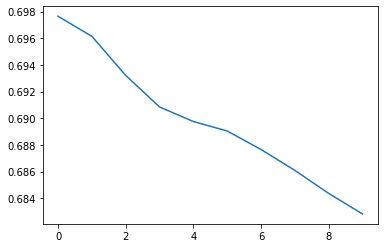

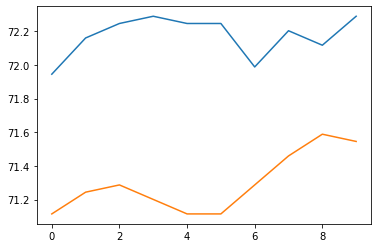

In [12]:
# plt.plot(losses)
# plt.plot(losses_val)
# plt.legend(['train','val'])

# plt.figure()
# plt.plot(losses[200:])
# plt.plot(losses_val[200:])
# plt.legend(['train','val'])

print(lambda_)

plt.plot(outer_loss.detach().numpy())
plt.figure()
plt.plot(accuracy_train_outer.detach().numpy())
plt.plot(accuracy_val_outer.detach().numpy())

Finally, we compute the model performance on the test set


In [13]:
outputs_test = torch.squeeze(model(x_test))

total_test = y_test.size(0)

loss_test_final = CE_weight_decay(outputs_test, y_test,lambda_, vectorized_params)

predicted_test = torch.argmax(torch.nn.functional.softmax(outputs_test), dim = 1).detach().numpy()
total_val = y_test.size(0)

correct_test = np.sum(predicted_test == y_test.detach().numpy())
accuracy_test_final = 100 * correct_test/total_test

print(loss_test)
print(accuracy_test_final)

tensor(0.6702, grad_fn=<AddBackward0>)
70.13769363166953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


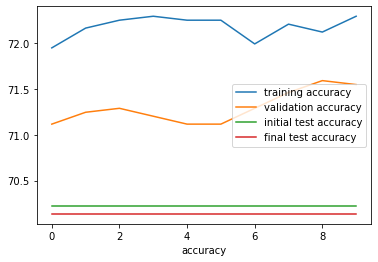

In [14]:
plt.plot(accuracy_train_outer.detach().numpy())
plt.plot(accuracy_val_outer.detach().numpy())
plt.xlabel('outer iterations')
plt.xlabel('accuracy')

plt.plot(np.arange(maxiter_outer),accuracy_test*np.ones(maxiter_outer))
plt.plot(np.arange(maxiter_outer),accuracy_test_final*np.ones(maxiter_outer))
plt.xlabel('outer iterations')
plt.xlabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy', 'initial test accuracy', 'final test accuracy'])